# Classes and variables

In [1]:
from birdclassification.preprocessing.filtering import filter_recordings_30
from torch.utils.data import DataLoader
import torch
from sklearn.model_selection import train_test_split
from training.dataset import Recordings30
from birdclassification.visualization.plots import plot_torch_spectrogram
from training.cnn_training_torch.CNN_model import CNNNetwork
from torchsummary import summary

In [2]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"
    
SEED = 123
RECORDINGS_DIR = '/Users/zosia/Desktop/recordings_30/'
NOISES_DIR = '/Users/zosia/Desktop/noises/'

SAMPLE_RATE = 32000
NUM_SAMPLES = SAMPLE_RATE * 1
BATCH_SIZE = 64

# Prepare dataset and dataloaders

In [3]:
df = filter_recordings_30("../../data/xeno_canto_recordings.csv", "../../data/bird-list-extended.csv", )

train_df, test_val_df = train_test_split(df, stratify=df['Latin name'], test_size=0.2, random_state = SEED)
val_df, test_df = train_test_split(test_val_df, stratify=test_val_df['Latin name'], test_size=0.5, random_state = SEED)

train_ds = Recordings30(train_df, recording_dir=RECORDINGS_DIR, noises_dir=NOISES_DIR, sample_rate=SAMPLE_RATE, device = DEVICE)
val_ds = Recordings30(val_df, recording_dir=RECORDINGS_DIR, noises_dir=NOISES_DIR, device = DEVICE)
test_ds = Recordings30(test_df, recording_dir=RECORDINGS_DIR, noises_dir=NOISES_DIR, device = DEVICE)

train_dl  = DataLoader(train_ds, batch_size= BATCH_SIZE)
val_dl  = DataLoader(val_ds, batch_size= BATCH_SIZE)
test_dl  = DataLoader(test_ds, batch_size= BATCH_SIZE)

/Users/zosia/Desktop/Bird-classification-model/birdclassification/preprocessing/filtering.py:45: DtypeWarning: Columns (10,39,43,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  recordings = pd.read_csv(filepath_recordings)


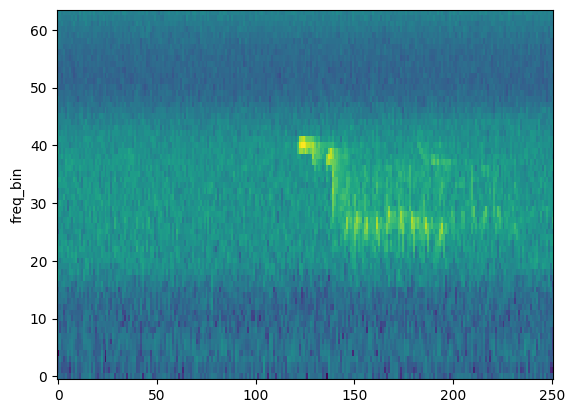

In [4]:
from torchaudio import transforms
from birdclassification.visualization.plots import plot_waveform
audio, label = train_ds[0]
plot_torch_spectrogram(audio)

In [5]:
cnn = CNNNetwork().to(DEVICE)
summary(cnn, (1, 64, 251)) 

input torch.Size([2, 1, 64, 251])
conv1 torch.Size([2, 16, 33, 126])
conv2 torch.Size([2, 32, 17, 64])
conv3 torch.Size([2, 64, 9, 33])
conv4 torch.Size([2, 128, 5, 17])
flatten torch.Size([2, 10880])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 66, 253]             160
              ReLU-2          [-1, 16, 66, 253]               0
         MaxPool2d-3          [-1, 16, 33, 126]               0
            Conv2d-4          [-1, 32, 35, 128]           4,640
              ReLU-5          [-1, 32, 35, 128]               0
         MaxPool2d-6           [-1, 32, 17, 64]               0
            Conv2d-7           [-1, 64, 19, 66]          18,496
              ReLU-8           [-1, 64, 19, 66]               0
         MaxPool2d-9            [-1, 64, 9, 33]               0
           Conv2d-10          [-1, 128, 11, 35]          73,856
             ReLU-11          

In [6]:
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

In [7]:
loss_fn = torch.nn.CrossEntropyLoss()

In [8]:
from datetime import datetime
import sys
from training.training_utils import train_one_epoch
from torch.utils.tensorboard import SummaryWriter
from training.validation_metrics import calculate_metric
from sklearn.metrics import f1_score

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'logs/fashion_trainer_{timestamp}')
epoch_number = 0

EPOCHS = 7

best_vloss = sys.float_info.max

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    
    # Make sure gradient tracking is on, and do a pass over the data
    cnn.train(True)
    avg_loss = train_one_epoch(epoch_number, writer, train_dl, optimizer, loss_fn, cnn)
    
    # Set the model to evaluation mode, disabling dropout and using population 
    # statistics for batch normalization.
    cnn.eval()
    running_vloss = 0.0

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(val_dl):
            vinputs, vlabels = vdata
            voutputs = cnn(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss
    
    avg_vloss = running_vloss / (i + 1)
    print("#############################################################")
    print("Epoch results:")
    print(f'Loss train {avg_loss} valid loss: {avg_vloss}')
    validation_f1_score = calculate_metric(cnn, val_dl, metric=f1_score)
    train_f1_score = None
    print(f'F1 score train {train_f1_score} valid f1 score {validation_f1_score}')
    print("#############################################################\n\n")
    
    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    
    
    writer.add_scalars('Macro_averaged_f1_score',
                    { 'Validation' : validation_f1_score},
                    epoch_number + 1)
    
    writer.flush()
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f'model_{timestamp}_{epoch_number}'
        torch.save(cnn.state_dict(), model_path)
    
    epoch_number += 1

/Library/Python/3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


EPOCH 1:


RuntimeError: stack expects each tensor to be equal size, but got [64, 251] at entry 0 and [64, 249] at entry 26

## Tests